<center><h1>Safe Driver Prediction</h1></center>
<center><h2>Capstone project by</h2></center>
<center><h2>Murali Mandayam</h2></center>
<center><h3>8th March 2019</h3></center>
<center><h3>www.thinkful.com</h3></center>


Data science has risen to prominence in the last decade due to its capabilities in predictive algorithms. While many business verticals value the benefits of predictive algorithms using Data Science, insurance companies place a lot of importance as data science and predictive algorithms helps them keeps premium low. Data is always been at the core of what insurance companies do analyzing data such as claims, what kind of a vehicle one drives, how many miles do they drive per day among other.
<br><br>
The data science field is gaining strength with improvements in technology, availability of statistical libraries to compute regression or classifications of data collected. Actuaries, the data scientists at insurance companies as they were called a decade ago, used to collate data from different sources and analyze the premium and claim data to identify fraudulent transactions that helped them keep the premiums low. If anything, data science technology of today has given far more tools to perform their analysis.
<br><br>
This Capstone project for Supervised Learning uses data from Kaggle (https://www.kaggle.com/mu202199/safe-driver-prediction). The data has a few ordinal, categorical data that needs to be parsed and categorized properly.
<br><br>
Our goal is to predict a binary outcome of 1, to indicate safe driver, or 0, to indicate that the drivers' data needs a review. We will also look at the continuous variables and fill in the missing data with the mean or median in order to not skew our results.
<br><br>
After cleaning up the data and filling in missing data we will look at the features and their correlation so that we can drop highly correlated data which may impact our results.
<br><br>
References:
<br>
1. https://www.kaggle.com/mu202199/safe-driver-prediction - for dataset
2. https://github.com/ngbolin/PortoSeguroXGB - Kaggle project using Brazilian Insurance company data
3. https://www.datacamp.com/community/tutorials/categorical-data - For ideas on converting categorical data to numeric<br>
4. https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769 -For ideas on converting categorical data to numeric<br>

In [101]:
# Import the necessary packages of Python that we will/may use in this notebook
# pandas and numpy for dataframe creation and manipulation
# matplot lib for data visualization
# sklearn for statistical algorithms and splitting the dataset to training and testing datasets

# General 
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

# Features pre-processing and principal component analysis (pca) 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# Train-test split
from sklearn.model_selection import train_test_split

# Classifiers 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Classifiers ensembling
#from xgboost.sklearn import XGBClassifier
#import xgboost as xgb
#from mlxtend.classifier import StackingClassifier

# Classifiers evaluation metrics
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

# Random resampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Tuning hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Other
from time import time
from scipy.stats import ttest_ind

# Ploting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
from IPython.display import display
pd.options.display.float_format = '{:.3f}'.format

# Suppressing annoying harmless error
import warnings
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [102]:
# Read the data from the local drive

safe_driver = pd.read_excel('IT_3.xlsx')

In [103]:
# Check if the data has any negaitve values

safe_driver.where(safe_driver < 0).sum()

ID                                                                     0.000
target                                                                 0.000
Gender                     FFMMMFFFFFMFFFMMMFMFMMMMFFMMMFMFMMMFFMMFMMMMMM...
EngineHP                                                               0.000
credit_history                                                         0.000
Years_Experience                                                       0.000
annual_claims                                                          0.000
Marital_Status             MarriedMarriedMarriedMarriedMarriedMarriedMarr...
Vehicle_Type               CarCarVanVanVanTruckTruckCarCarTruckUtilityTru...
Miles_driven_annually                                                  0.000
size_of_family                                                         0.000
Age_bucket                 <1828-34>4018-27>40>40>40>40>4035-40>4035-40>4...
EngineHP_bucket            >350>35090-16090-16090-16090-16090-160<90>3509...

In [104]:
# Check if there are any NULL data that need to be dropped
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 17 columns):
ID                              30240 non-null int64
target                          30240 non-null int64
Gender                          30240 non-null object
EngineHP                        30240 non-null int64
credit_history                  30240 non-null int64
Years_Experience                30240 non-null int64
annual_claims                   30240 non-null int64
Marital_Status                  30240 non-null object
Vehicle_Type                    30240 non-null object
Miles_driven_annually           30232 non-null float64
size_of_family                  30240 non-null int64
Age_bucket                      30240 non-null object
EngineHP_bucket                 30240 non-null object
Years_Experience_bucket         30240 non-null object
Miles_driven_annually_bucket    30232 non-null object
credit_history_bucket           30240 non-null object
State                           3

In [105]:
safe_driver.describe()

,ID,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
count,30240.000,30240.000,30240.000,30240.000,30240.000,30240.000,30232.000,30240.000
mean,15120.500,0.708,196.604,685.770,13.256,1.138,17422.939,4.521
std,8729.680,0.455,132.347,102.454,9.890,1.083,17483.783,2.287
min,1.000,0.000,80.000,300.000,1.000,0.000,5000.000,1.000
25%,7560.750,0.000,111.000,668.000,5.000,0.000,9668.500,3.000
50%,15120.500,1.000,141.000,705.000,10.000,1.000,12280.000,5.000
75%,22680.250,1.000,238.000,753.000,20.000,2.000,14697.250,7.000
max,30240.000,1.000,1005.000,850.000,40.000,4.000,99943.000,8.000


In [106]:
# Check and see if we have an imbalanced class label in the dataset
# Calculate the percentage of success data ('target' == 1) with respect to the failure data ('target' == 0)

true_claims = (safe_driver['target'] == 1).sum()
print('True Claims is  {}'.format(true_claims))

total_records = len(safe_driver['target'])
print('Total number of records is {}'.format(total_records))

print('The percentage of true claims is {}%'.format(round(true_claims / total_records * 100), 2))

True Claims is  21396
Total number of records is 30240
The percentage of true claims is 71.0%


Our dataset is indeed imbalanced. We will balance it later using SMOTE technique.

The dataset contains several categorical data that ends with **bucket** that need to be either dropped or converted to numerical values using dummies. All features that are of type object are categorical variables that needs to either:<br>
<br>
a. Converted to numeric using dummies<br>
b. Dropped or<br>
c. Assigned a binary value<br>

In [107]:
cat_features = safe_driver.select_dtypes(include=['object']).copy()
print(cat_features.columns)

Index(['Gender', 'Marital_Status', 'Vehicle_Type', 'Age_bucket',
       'EngineHP_bucket', 'Years_Experience_bucket',
       'Miles_driven_annually_bucket', 'credit_history_bucket', 'State'],
      dtype='object')


Among the categorical variables we retain the following:<br>
<br>
1. Gender<br>
2. Marital_Status<br>
3. Vehicle_Type, and<br>
4. Age_bucket<br>
<br>
EngineHP_bucket, Years_Experience_bucket, Miles_driven_annually_bucket, credit_history_bucket have a corresponding continuous variable. Creating each with their own dummies along with the continuous variable does not make sense. We will keep the Age_bucket as there is no continuous variable to represent age.<br>
<br>
We can split the dataset by State (one sub-dataset for each state) and analyze each state by itself. As each US state has its own regulations it may make sense to analyze each state by itself. We could aggregate our results across states later to get a national statistic.<br>
<br>
Or, for now, we could drop the State column and analyze the data across the nation later.

In [108]:
# Drop these 5 columns: ID, EngineHP_bucket, Years_Experience_bucket, Miles_driven_annually_bucket, credit_history_bucket

safe_driver.drop(['ID', 'EngineHP_bucket', 'Years_Experience_bucket', 
                  'Miles_driven_annually_bucket', 
                  'credit_history_bucket'], axis=1, inplace=True)

In [109]:
# Check if the dataset has any NaN values as these values will make our algorithms throw an exception

safe_driver.isnull().sum()

target                   0
Gender                   0
EngineHP                 0
credit_history           0
Years_Experience         0
annual_claims            0
Marital_Status           0
Vehicle_Type             0
Miles_driven_annually    8
size_of_family           0
Age_bucket               0
State                    0
dtype: int64

The Miles_driven_annually feature has some null values. Let us explore which particular cells have NaN and ingest them with the median data.

In [110]:
safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehicle_Type,Miles_driven_annually,size_of_family,Age_bucket,State
1235,1,F,124,793,27,0,Married,Truck,nan,3,>40,NJ
7365,0,F,465,696,5,0,Married,Truck,nan,8,18-27,SD
11464,1,F,137,787,18,1,Married,Truck,nan,1,>40,CT
18158,0,F,108,747,8,1,Married,Truck,nan,1,18-27,OR
19795,1,F,121,774,19,0,Married,Truck,nan,2,28-34,NY
25731,1,F,355,694,15,1,Married,Truck,nan,5,28-34,CT
26512,1,F,109,743,40,0,Married,Truck,nan,1,>40,OR
27045,1,F,83,784,21,0,Married,Truck,nan,1,>40,CT


It may make sense to ingest the median of  `Vehicle_Type=='Truck'` as all the NaN values are for Truck only. Let us look at the median of Miles_driven_annually by each vehicle type. 

In [111]:
median_values = safe_driver.groupby('Vehicle_Type').median()
median_values

,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
Vehicle_Type,,,,,,,
Car,1,148,695,7,1,13147.500,4
Truck,1,150,694,8,1,12370.500,5
Utility,1,132,741,14,1,11117.000,5
Van,1,128,721,15,1,11272.000,5


In [112]:
# Replace NaN values in Miles_driven_annually with the median value for Truck
# There may be better ways to impute missing data. But we have just 8 NaN cells out of some 30,000+ rows which is
# less than 0.03%
# So, imputing with median for all the 8 cells is not going to skew our results.

safe_driver.fillna(median_values.loc[ 'Truck', 'Miles_driven_annually'], inplace=True)

In [113]:
# Check for null values again to make sure we did not miss any accidentally

safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehicle_Type,Miles_driven_annually,size_of_family,Age_bucket,State


In [114]:
# Check the data types of all remaining features

safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 12 columns):
target                   30240 non-null int64
Gender                   30240 non-null object
EngineHP                 30240 non-null int64
credit_history           30240 non-null int64
Years_Experience         30240 non-null int64
annual_claims            30240 non-null int64
Marital_Status           30240 non-null object
Vehicle_Type             30240 non-null object
Miles_driven_annually    30240 non-null float64
size_of_family           30240 non-null int64
Age_bucket               30240 non-null object
State                    30240 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.8+ MB


Looking at the feature values above, the range of values of each vary a lot. For example `'Miles_driven_annually'` is in the 10s of thousands, whereas 'credit_history' is in the 100s and 'annual-claims' is in single digit. Due to the varying magnitudes of the feature values we will scale the features with Z-scores using `sklearn.preprocessing.scale`.<br>
<br>

In [115]:
# To standardize the numeric features we need to isolate them first into a separate dataframe

safe_driver_num_features = safe_driver.drop(safe_driver.select_dtypes(['object']), axis=1)

# Do not standardize 'target' which is our label

safe_driver_num_features.drop(['target'], axis=1, inplace=True)

safe_driver_cat_features = safe_driver.select_dtypes(['object'])

In [116]:
# Check if there are any NaN values one more time

safe_driver_num_features[safe_driver_num_features.isnull().any(axis=1)]

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family


In [117]:
from sklearn import preprocessing

# Restore the column names from the original dataset

safe_driver_scaled = pd.DataFrame(preprocessing.scale(safe_driver_num_features), 
                                  columns=safe_driver_num_features.columns)

# We now have the scaled feature set. Now we need to concatenate the categorical features back with our scaled
# dataset before running OneHotEncoder or dummies.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


In [118]:
# We will concatenate the scaled dataframe with the categorical feature set

safe_driver = pd.concat([safe_driver_scaled, safe_driver['target'], safe_driver_cat_features], axis=1)

In [119]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehicle_Type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,F,Married,Car,<18,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,F,Married,Car,28-34,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,M,Married,Van,>40,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,M,Married,Van,18-27,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,M,Married,Van,>40,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,F,Married,Truck,>40,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,F,Married,Truck,>40,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,F,Single,Car,>40,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,F,Married,Car,>40,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,F,Married,Truck,35-40,NJ


Let us use data visualization techniques to find the distribution of the features and also the correlation between different features. We could, may be, drop one or two more features based on distribution or correlation making our dataset cleaner.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


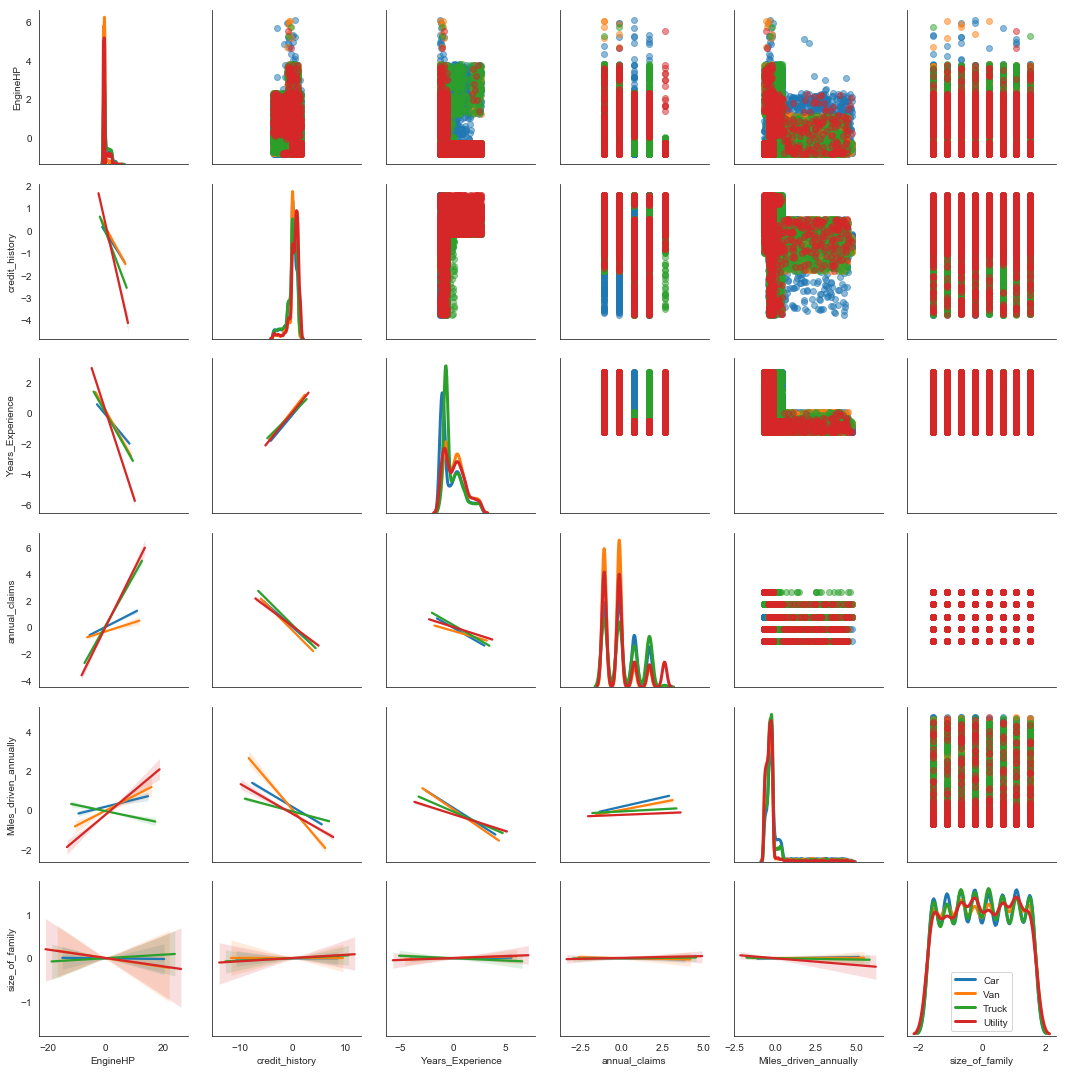

In [120]:
# Create a scatterplot matrix that shows all the bivariate relationships in one plot made up of subplots.
# Let us drop the 'target' variable

safe_driver_copy = safe_driver.drop(['target'], axis=1)

# Plot with the remaining feature set

g = sns.PairGrid(safe_driver_copy.dropna(), diag_sharey=False, hue='Vehicle_Type')
# As in the Unit 2 lesson example, create a Scatterplot in the top-right diagonal
g.map_upper(plt.scatter, alpha=.5)
# Linear relationship of two variables in the bottom-left diagonal
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# And...univariate distributions of the variables across the diagonal
g.map_diag(sns.kdeplot, lw=3)
plt.legend()
plt.show()

# The legend appears at the bottom-right plot


Our next step is to output a correlation heatmap that can tell us correlation coefficient of the features. If two variables are highly corrrelated our results could be incorrect or skewed.<br>
<br>
First we have to isolate the continuous variables in a dataframe before invoking the heatmap.<br>
<br>
Let us create the heatmap.

In [121]:
safe_driver_num_features = safe_driver.drop(['Gender', 'Marital_Status', 'Age_bucket', 'Vehicle_Type'], axis=1)

[]

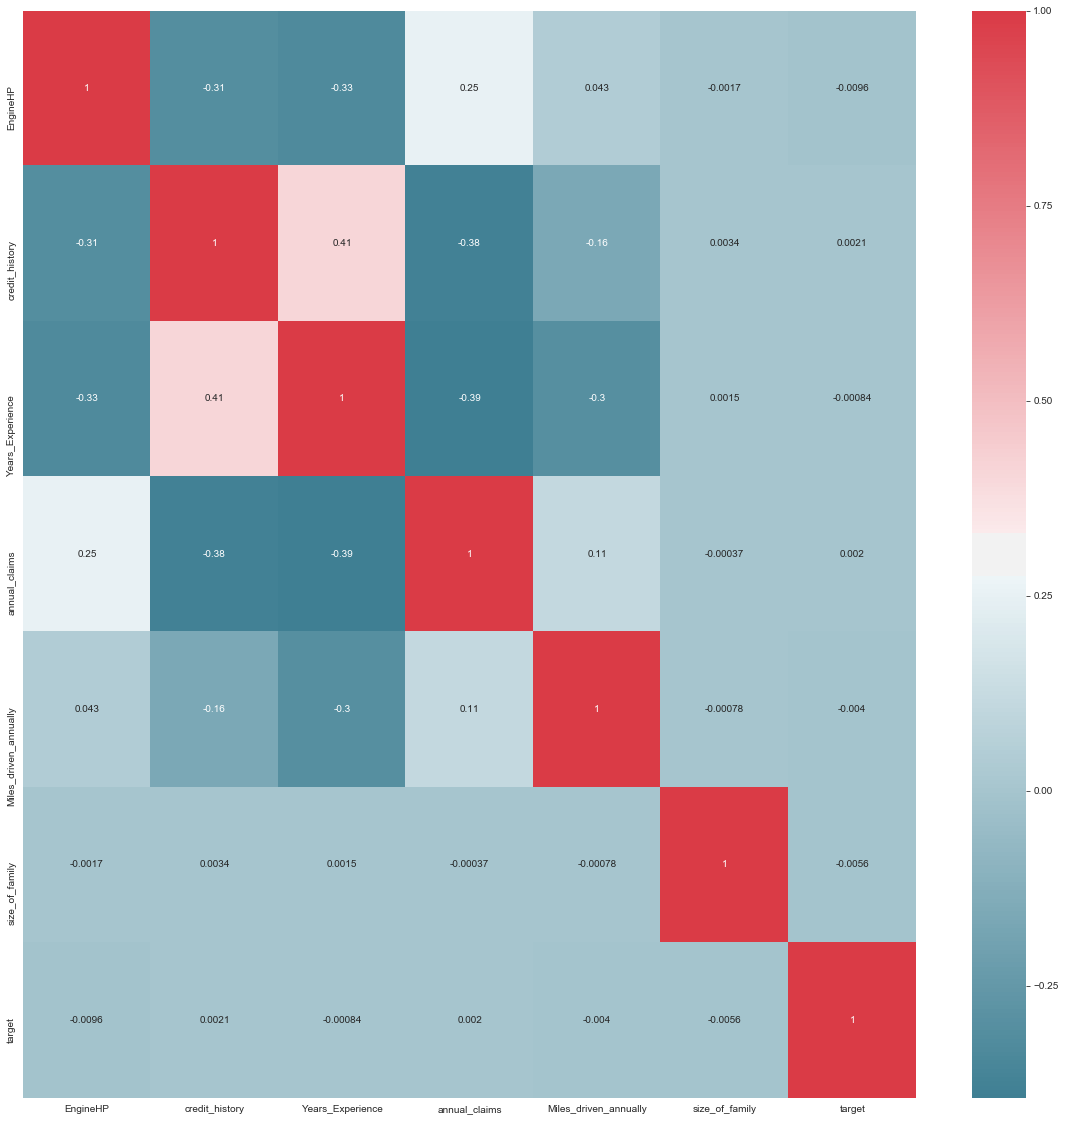

In [122]:
sns.set_style('white')
color_map = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(20, 20))
sns.heatmap(safe_driver_num_features.corr(), annot = True, cmap = color_map)
plt.plot()

The features are not highly correlated with our target variable. We can keep the remaining features as it is.

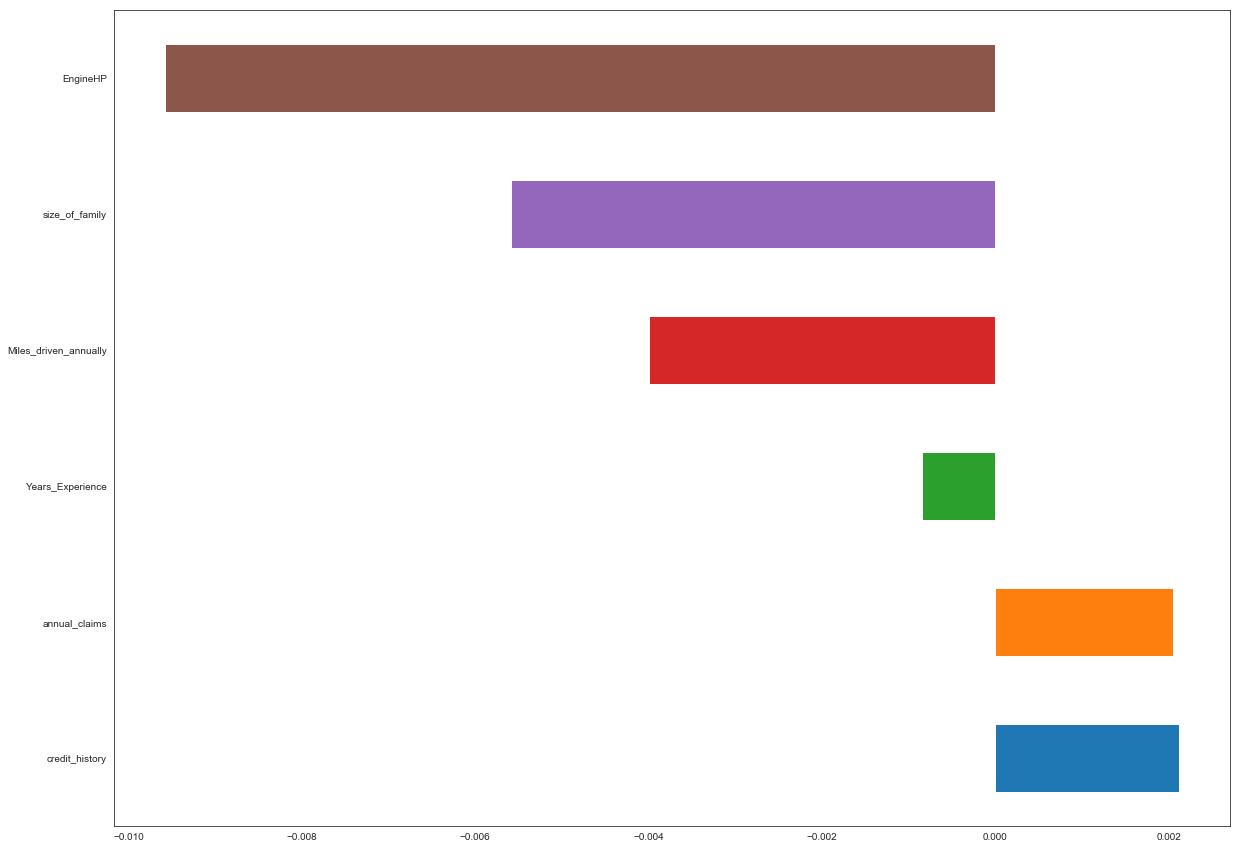

In [123]:
plt.figure(figsize=(20, 15))
(safe_driver_num_features.corr()
     .target
     .drop('target')
     .sort_values(ascending=False)
     .plot
     .barh()) 

Here, below, we separate our feature set from the label `target` and convert all the categorical variables to numeric. Then split the feature set into training and test data sets.

In [124]:
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 12 columns):
EngineHP                 30240 non-null float64
credit_history           30240 non-null float64
Years_Experience         30240 non-null float64
annual_claims            30240 non-null float64
Miles_driven_annually    30240 non-null float64
size_of_family           30240 non-null float64
target                   30240 non-null int64
Gender                   30240 non-null object
Marital_Status           30240 non-null object
Vehicle_Type             30240 non-null object
Age_bucket               30240 non-null object
State                    30240 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 2.8+ MB


Let us convert some of the categorical features into numeric giving weightage to each variable.<br>
<br>
1. Gender: 1 = Female and 2 = Male<br>
2. Marital_Status: 1 = Single and 2 = Married<br>
3. Vehicle_Type: 1 = Car; 2 = Van; 3 = Utility and 4 = Truck; Use `LabelEncoder`<br>
4. Age_bucket: Use `LabelEncoder`<br>
<br>
We are not using `dummies` or `OneHotEncoder` because these create sparse matrices and increase dimensionality. By giving a 1 or a 2 for say Marital_Status we give higher weightage to `Married` by assigning a value of 2.

In [125]:
# Convert Gender to a 1 or a 2
safe_driver['Gender'] = np.where(safe_driver['Gender']=='F', 1, 2)

# Convert Marital_Status to a 1 or a 2
safe_driver['Marital_Status'] = np.where(safe_driver['Marital_Status']=='Single', 1, 2)

# Convert Vehicle_Type using LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(safe_driver['Vehicle_Type'])

safe_driver['Vehicle_Type'] = le.transform(safe_driver['Vehicle_Type'])

# Convert Age_bucket using LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(safe_driver['Age_bucket'])

safe_driver['Age_bucket'] = le.transform(safe_driver['Age_bucket'])

In [126]:
safe_driver.head(10)

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family,target,Gender,Marital_Status,Vehicle_Type,Age_bucket,State
0,2.459,-0.291,-1.239,-1.051,-0.153,0.209,1,1,2,0,3,IL
1,3.736,0.178,0.277,-1.051,-0.116,0.647,1,1,2,0,1,NJ
2,-0.481,0.051,0.176,-1.051,-0.427,-0.665,1,2,2,3,4,CT
3,-0.382,0.334,-0.430,-1.051,3.427,-0.665,1,2,2,3,0,CT
4,-0.518,0.832,1.996,-0.128,-0.185,-0.228,1,2,2,3,4,WY
5,-0.397,0.354,0.480,-0.128,-0.298,1.521,1,1,2,1,4,DE
6,-0.345,0.998,1.794,1.719,-0.198,-1.103,1,1,2,1,4,NJ
7,-0.821,0.598,0.783,-0.128,-0.184,0.209,1,1,1,0,4,ME
8,3.449,0.305,2.097,-1.051,-0.019,-1.540,1,1,2,0,4,CA
9,-0.579,0.969,0.581,-0.128,-0.648,-1.540,0,1,2,1,2,NJ


In [127]:
# Drop the 'target' column from training dataframe as that is our label
X = safe_driver.drop(['target', 'State'], 1)

# The 'target' column is our label or outcome that we want to predict
y = safe_driver['target']

# Use pd.dummies to resolve the categorical data (e.g. State) into numerical values
#X = pd.get_dummies(X)

# Drop and NaN values
X = X.dropna(axis=1)

We found out much earlier that our target label is 70% failure (bad driver or `target` == 1) and 30% success (good driver or `target` == 0). Let us do class balancing using SMOTE and see the distribution.<br>

In [128]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)

columns = X.columns
os_data_X, os_data_y = os.fit_sample(X, y)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns )
os_data_y = pd.DataFrame(data=os_data_y, columns=['y'])

#Split the resulting balanced data set as train and test

X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)

# Check the size of our new data
print("length of oversampled data is ",len(os_data_X))
print("Number of negative class in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of positive class in oversampled data",len(os_data_y[os_data_y['y']==1]))
print("Proportion of negative class in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of positive class in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  42792
Number of negative class in oversampled data 21396
Number of positive class in oversampled data 21396
Proportion of negative class in oversampled data is  0.5
Proportion of positive class in oversampled data is  0.5


Let us find out how significant are our features are in predicting our label. We will use the feature_importances_ method from the RandomForestClassifier. After that we plot the relative importance of the features using a barplot.<br>
<br>
Let us go ahead and select our categorical features, using a RandomForestClassifier.

In [129]:
# Find out the feature importance using RandomForest

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=12)
regr.fit(X, y)

# The features identified by RandomForest will be our columns for the training and testing dataset

feature_importances = pd.DataFrame(regr.feature_importances_, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

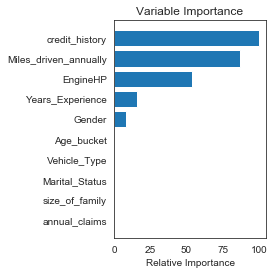

In [150]:
feature_importance = regr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [131]:
# Run LogisticRgression model on the training data set

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_predict = tree.predict(X_test)
tree.score(X_test, y_test) 

0.6659915874746846

In [132]:
# Function to calculate Accuracy, Error, Sensitivity and Specificity from the returned results.
target_names = ['Safe Driver', 'Non-safe Driver']
print('Scores from DecisionTree model:\n', classification_report(y_test, y_predict, target_names=target_names))

Scores from DecisionTree model:
                  precision    recall  f1-score   support

    Safe Driver       0.66      0.68      0.67      6418
Non-safe Driver       0.67      0.65      0.66      6420

      micro avg       0.67      0.67      0.67     12838
      macro avg       0.67      0.67      0.67     12838
   weighted avg       0.67      0.67      0.67     12838



In [133]:
# Print confusion matrix for DecisionTreeClassifier
confusion_matrix(y_test, y_predict)

array([[4384, 2034],
       [2254, 4166]])

In [134]:
# Our confusion matrix based on the DecisionTree does not look good. It is showing a high number of
# false positives and false negatives

In [135]:
# Run Support Vector Classifier to verify accuracy

from sklearn.svm import SVC
svc = SVC(gamma='auto')

svc.fit(X_train, y_train)

y_predict = svc.predict(X_train)

svc.score(X_train, y_train)

from sklearn.model_selection import cross_val_score
cross_val_score(svc, X_train, y_train, cv=5)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

array([0.52086115, 0.52411951, 0.51443832, 0.52270451, 0.5245409 ])

Though SVC returns better scores, all the predictions it made are of the success class only. This is worrisome

In [136]:
# Function to calculate Accuracy, Error, Sensitivity and Specificity from the returned results.
target_names = ['Safe Driver', 'Non-safe Driver']
print('Scores from SVC model:\n', classification_report(y_train, y_predict, target_names=target_names))

Scores from SVC model:
                  precision    recall  f1-score   support

    Safe Driver       0.55      0.68      0.60     14978
Non-safe Driver       0.58      0.44      0.50     14976

      micro avg       0.56      0.56      0.56     29954
      macro avg       0.56      0.56      0.55     29954
   weighted avg       0.56      0.56      0.55     29954



In [137]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_predict)

array([[10127,  4851],
       [ 8381,  6595]])

In [138]:
# Let us also run the SGDClassifier model to verify

from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-3)
clf.fit(X_train, y_train)

y_predict_SGD = clf.predict(X_train)

clf.score(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.4962275489083261

In [139]:
# Function to calculate Accuracy, Error, Sensitivity and Specificity from the returned results.
target_names = ['Safe Driver', 'Non-safe Driver']
print('Scores from SGD model:\n', classification_report(y_train, y_predict, target_names=target_names))

Scores from SGD model:
                  precision    recall  f1-score   support

    Safe Driver       0.55      0.68      0.60     14978
Non-safe Driver       0.58      0.44      0.50     14976

      micro avg       0.56      0.56      0.56     29954
      macro avg       0.56      0.56      0.55     29954
   weighted avg       0.56      0.56      0.55     29954



In [140]:
confusion_matrix(y_train, y_predict_SGD)

array([[ 4003, 10975],
       [ 4115, 10861]])

Trying SVC again with better tuning parameters found out from StackOverflow.

In [141]:
from sklearn.svm import SVC

classifier = SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

classifier = classifier.fit(X_train, y_train)

y_predict = classifier.predict(X_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [142]:
confusion_matrix(y_train, y_predict)

array([[10362,  4616],
       [ 7567,  7409]])

In [143]:
# Function to calculate Accuracy, Error, Sensitivity and Specificity from the returned results.
target_names = ['Safe Driver', 'Non-safe Driver']
print('Scores from SVC model:\n', classification_report(y_train, y_predict, target_names=target_names))

Scores from SVC model:
                  precision    recall  f1-score   support

    Safe Driver       0.58      0.69      0.63     14978
Non-safe Driver       0.62      0.49      0.55     14976

      micro avg       0.59      0.59      0.59     29954
      macro avg       0.60      0.59      0.59     29954
   weighted avg       0.60      0.59      0.59     29954



In [144]:
from sklearn.linear_model import RidgeClassifier
#
clf = RidgeClassifier().fit(X_train, y_train)
clf.score(X_train, y_train) 
y_predict = classifier.predict(X_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [145]:
target_names = ['Safe Driver', 'Non-safe Driver']
print('Scores from Ridge Classifier model:\n', classification_report(y_train, y_predict, target_names=target_names))

Scores from Ridge Classifier model:
                  precision    recall  f1-score   support

    Safe Driver       0.58      0.69      0.63     14978
Non-safe Driver       0.62      0.49      0.55     14976

      micro avg       0.59      0.59      0.59     29954
      macro avg       0.60      0.59      0.59     29954
   weighted avg       0.60      0.59      0.59     29954



In [147]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(loss = 'deviance', max_depth=10)
clf_model = clf.fit(X_train, y_train)
print(clf_model)
print('Training set score:', clf.score(X_train, y_train))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Training set score: 0.9003805835614609


In [148]:
CLF_score = cross_val_score(clf, X_train, y_train, cv=5)
print('\nEach Cross Validated Accuracy: \n', CLF_score)
print("\nOverall Gradient Boosted Classifier Accuracy: %0.2f (+/- %0.2f)\n" % (CLF_score.mean(), CLF_score.std() * 2))

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin


Each Cross Validated Accuracy: 
 [0.75500668 0.74661993 0.75196128 0.74307179 0.75141903]

Overall Gradient Boosted Classifier Accuracy: 0.75 (+/- 0.01)



In [149]:
y_predict = clf.predict(X_train)
target_names = ['Safe Driver', 'Non-safe Driver']
print('Scores from GradientBoostClassifier model:\n', classification_report(y_train, y_predict, 
                                                                            target_names=target_names))
confusion_matrix(y_train, y_predict)

Scores from GradientBoostClassifier model:
                  precision    recall  f1-score   support

    Safe Driver       1.00      0.80      0.89     14978
Non-safe Driver       0.84      1.00      0.91     14976

      micro avg       0.90      0.90      0.90     29954
      macro avg       0.92      0.90      0.90     29954
   weighted avg       0.92      0.90      0.90     29954



array([[12049,  2929],
       [   55, 14921]])